## **Importar librerías**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MakeSens import MakeSens
import matplotlib as mpl
import matplotlib.dates as mdates     # Fechas en las graficas

plt.style.use('seaborn-v0_8-ticks')

## **Funciones de Análisis de datos**

### **Parámetros de gráficas y función de traducción de etiquetas**

In [2]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

def translate_time(text,pos):
    """
    text: es de la forma 'Sun-10'
    pos: es de la forma (19526.0, 0)
    """
    day, num = text.split('-')
    if day == 'Sun': day = 'DO'
    elif day == 'Mon': day = 'LU' 
    elif day == 'Tue': day = 'MA'
    elif day == 'Wed': day = 'MI'
    elif day == 'Thu': day = 'JU'
    elif day == 'Fri': day = 'VI'
    elif day == 'Sat': day = 'SA'
    return pos[0], day+'-'+num

### **Funciones principales**

In [26]:
def obtener_datos(estacion, start, end):
    """
    # Params
    estacion: str. Nombre estacion miniEva
    start: str. Fecha de inicio: año-mes-día hora:minuto:segundo
    end: str. Fecha de fin:      año-mes-día hora:minuto:segundo
    """
    data = MakeSens.download_data(estacion, start, end, 'm') # Descargar los datos
    data.index = pd.DatetimeIndex(data.index)                # Convertir a tipo datetime el índice   
    return data

# Limpieza de datos de pm25. Para limpiar otras columnas, agreguelas a la lista limpieza_cols y a las listas sensor1, sensor2, merged para promediar los datos de los dos sensores.
def limpiar_datos(data, threshold = 120, CV_threshold = 0.3):
    """
    # Params
    threshold: float. Valor de corte de los datos de PM
    CV_threshold: float. Condición para aceptar promediar los datos de los sensores 1 y 2
    """
    ## Eliminamos datos por encima de threshold
    limpieza_cols = ['pm25_1','pm25_2','pm25_1_AE','pm25_2_AE']       # Columnas a las que hacemos limpieza de datos        
    for col in limpieza_cols:                                     # Iteramos entre cada columna
        data[col] = data[col].where(
                                    data[col]<threshold,  # Condición para conservar el dato
                                    np.nan)               # Valor por el que se reemplaza el dato si se incumple la condición anterior
    sensor1 = ['pm25_1','pm25_1_AE']
    sensor2 = ['pm25_2','pm25_2_AE']
    merged = ['pm25','pm25_AE']

    ## Calculamos coeficiente de variación
    mean = pd.DataFrame({})     # Promedios
    std = pd.DataFrame({})      # Desviaciones estandar
    CV = pd.DataFrame({})       # Coeficiente de variación
    for i in range(len(sensor1)):             # Iteramos entre cada columnas
        col1 = sensor1[i]                     # Nombre primera columna (sensor 1)
        col2 = sensor2[i]                     # Nombre segunda columna (sensor 2)
        mean[col1] = (data[col1] + data[col2])/2   # Promedio
        std[col1] = np.sqrt( (mean[col1]-data[col1])**2 + (mean[col1]-data[col2])**2 ) # Desviación estandar
        CV[col1] = std[col1]/mean[col1]            # Coeficiente de variación

    ## Analizamos si el tercer cuartil (Q3) de variación es menor a CV_threshold
    CV_Q3 = CV.quantile(0.75)
    for i in range(len(sensor1)):
        col1 = sensor1[i]                 # Nombre primera columna (sensor 1)
        col_new = merged[i]               # Nombre columna nueva
        if CV_Q3[col1] < CV_threshold:    # Si CV_mean < CV_threshold entonces guarda el promedio en el dataset
            data[col_new] = mean[col1]
        else: data[col_new] = data[col1]  # Si CV_mean no es menor a CV_threshold entonces toma el datos del sensor 1 por defecto
    return data

# Hacemos resampleo diario
def resampleo_datos(data):
    """
    # Params
    data: DataFrame. Conjunto de datos con las columnas pm25 y pm25_AE
    """
    dat = data[['pm25','pm25_AE']].resample('D').mean()             # Conjunto de datos con promedio diario
    dat_std = data[['pm25','pm25_AE']].resample('D').std()          # Conjunto de datos con desviación estandar diaria
    dat_Q1 = data[['pm25','pm25_AE']].resample('D').quantile(0.25)  # Conjunto de datos con cuartil Q1 diario
    dat_Q3 = data[['pm25','pm25_AE']].resample('D').quantile(0.75)  # Conjunto de datos con cuartil Q3 diario
    return dat, dat_std, dat_Q1, dat_Q3

def graficar_datos(dat, dat_std, dat_Q1, dat_Q3,
                   ax, label = 'PM2.5', titulo = 'Instituto Técnico Damazo Zapata', xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3):
    """
    # Params
    dat: DataFrame. Conjunto principal de datos.
    dat_std: DataFrame. Conjunto de datos de desviación estándar. Debe estar resampleado al igual que dat.
    dat_Q1: DataFrame. Conjunto de datos del cuartil 1. Debe estar resampleado al igual que dat.
    dat_Q3: DataFrame. Conjunto de datos del cuartil 3. Debe estar resampleado al igual que dat.
    ax: axis. Eje de una figura de matplotlib
    label: str. Etiquet a de los datos
    titulo: str. Título gráfico
    xlabel: str. Etiqueta eje x
    ylabel: str. Etiqueta eje y
    col: str. Columna de los datos. Debe estar en dat.
    alpha: float. transparencia del rellando entre curvas.
    unit_text: float. Distancia vertical entre el punto y su etiqueta.
    """
    locator = 'day'            # Resampleo de los datos
    date_formatter = '%a-%d'   # Formato de la fecha en el eje x

    # Graficas de líneas y relleno entre curvas
    dat[col].plot(ax=ax, label=label,marker='o', ms=7,color='blue')
    ax.fill_between(dat.index, dat[col]+dat_std[col],dat[col]-dat_std[col],alpha=alpha,color='red', label='Desviación estándar')
    ax.fill_between(dat.index, dat_Q1[col], dat_Q3[col],alpha=alpha,color='#1BD8D0')
    dat_Q1[col].plot(ax=ax, label='Cuartil Q1',linestyle='--',color='black', lw=2)
    dat_Q3[col].plot(ax=ax, label='Cuartil Q3',linestyle='--',color='blue', lw=2)

    # Ajustes de forma
    ## Agregar etiquetas a cada punto de datos
    for x, y in zip(dat.index, dat[col]):
        ax.text(x, y+unit_text,
                f"{y:.1f}", 
                ha="center", # Alineamiento horizontal
                va="bottom", # Alineamiento vertical
                fontsize=12, 
                fontweight="bold") , 
    ax.set_title(titulo, fontweight="bold")      # Titulo
    ax.set_xlabel(xlabel, fontweight="bold", fontsize=20)     # Etiqueta eje x
    ax.set_ylabel(ylabel, fontweight="bold", fontsize=20)     # Etiqueta eje y

    ## Convertir las fechas de las etiquetas del eje x a formato Mes-día
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_formatter))
    if locator=='day':
        ax.xaxis.set_major_locator(mdates.DayLocator())
    if locator=='month':
        ax.xaxis.set_major_locator(mdates.MonthLocator())

    l = plt.xticks()

    ticks = list(plt.xticks())
    pos_ticks=[]
    text_ticks=[]
    for Text in ticks[1]:
        pos, text = translate_time(Text.get_text(), Text.get_position())
        pos_ticks.append(pos)
        text_ticks.append(text)
    plt.xticks(pos_ticks, text_ticks)

    # Ajustes finales
    plt.legend()

## **Ejemplos**

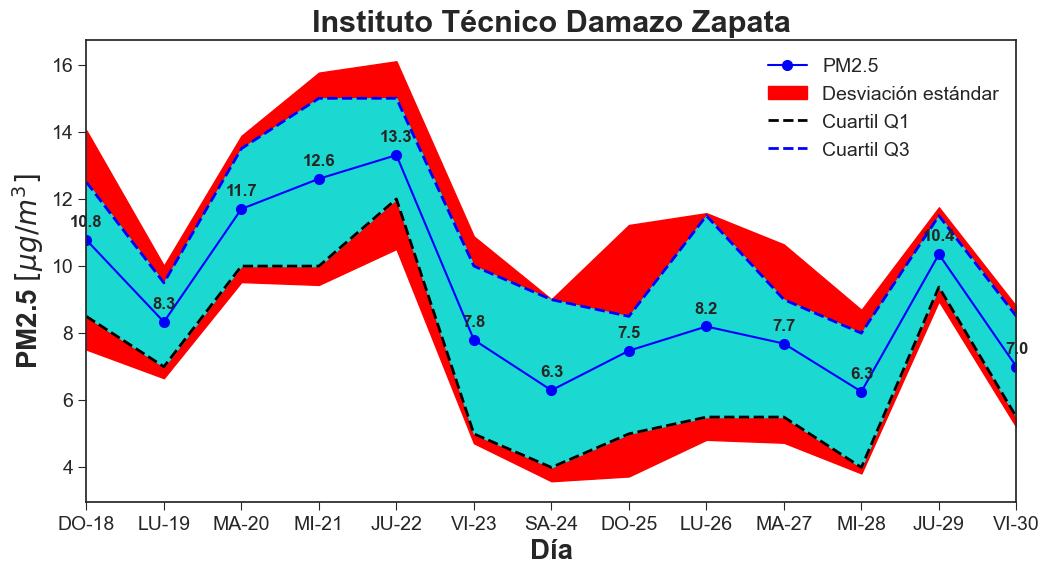

In [5]:
estacion = 'mE1_00004'           # Nombre estacion miniEva
start = '2023-06-18 00:00:00'    # Fecha de inicio: año-mes-día hora:minuto:segundo
end   = '2023-06-30 17:00:00'    # Fecha de fin:    año-mes-día hora:minuto:segundo

data = obtener_datos(estacion, start, end)
data = limpiar_datos(data, threshold = 120, CV_threshold = 0.3)
dat, dat_std, dat_Q1, dat_Q3 = resampleo_datos(data)

fig, ax = plt.subplots(figsize=(12,6))
graficar_datos(dat, dat_std, dat_Q1, dat_Q3,
                   ax, label = 'PM2.5', titulo = 'Instituto Técnico Damazo Zapata', xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3)

## **Análisis de datos de todas las estaciones**

In [14]:
## Estaciones y rango de tiempo de análisis
estaciones = ['mE1_00004','mE1_00006','mE1_00007','mE1_00008']
start = '2023-06-18 00:00:00'    # Fecha de inicio: año-mes-día hora:minuto:segundo
end   = '2023-06-30 20:00:00'    # Fecha de fin:    año-mes-día hora:minuto:segundo
colegios = {'mE1_00004':'Instituto Técnico Damazo Zapata', 
            'mE1_00006':'Institución Educativa Nuestra Señora del Pilar', 
            'mE1_00007':'Escuela Normal Superior', 
            'mE1_00008':'Fundación Colegio UIS'}
            
## Diccionarios que guardarán los datos de todas las estaciones
data = {}
dat = {}
dat_std = {}
dat_Q1 = {}
dat_Q3 = {}

## Obtenemos y limpiamos datos
for estacion in estaciones:
    data[estacion] = obtener_datos(estacion, start, end)
    data[estacion] = limpiar_datos(data[estacion], threshold = 120, CV_threshold = 0.3)
    dat[estacion], dat_std[estacion], dat_Q1[estacion], dat_Q3[estacion] = resampleo_datos(data[estacion])

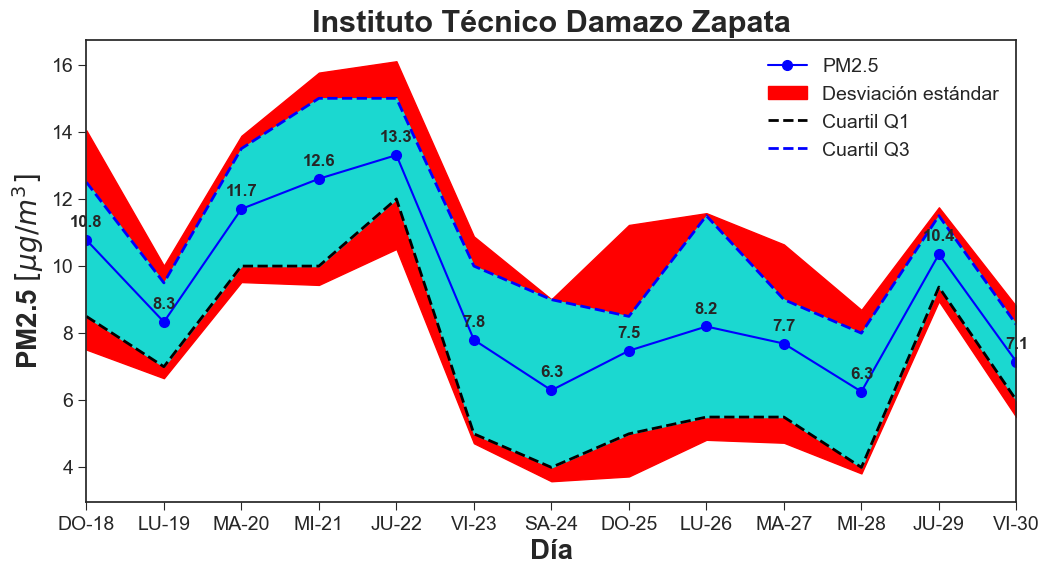

In [31]:
## Grafica mE1_00004
estacion = 'mE1_00004'
fig, ax = plt.subplots(figsize=(12,6))
graficar_datos(dat[estacion], dat_std[estacion], dat_Q1[estacion], dat_Q3[estacion],
                   ax, label = 'PM2.5', titulo = colegios[estacion], xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3)
plt.savefig('images/grafica'+estacion+'.png',dpi=400)

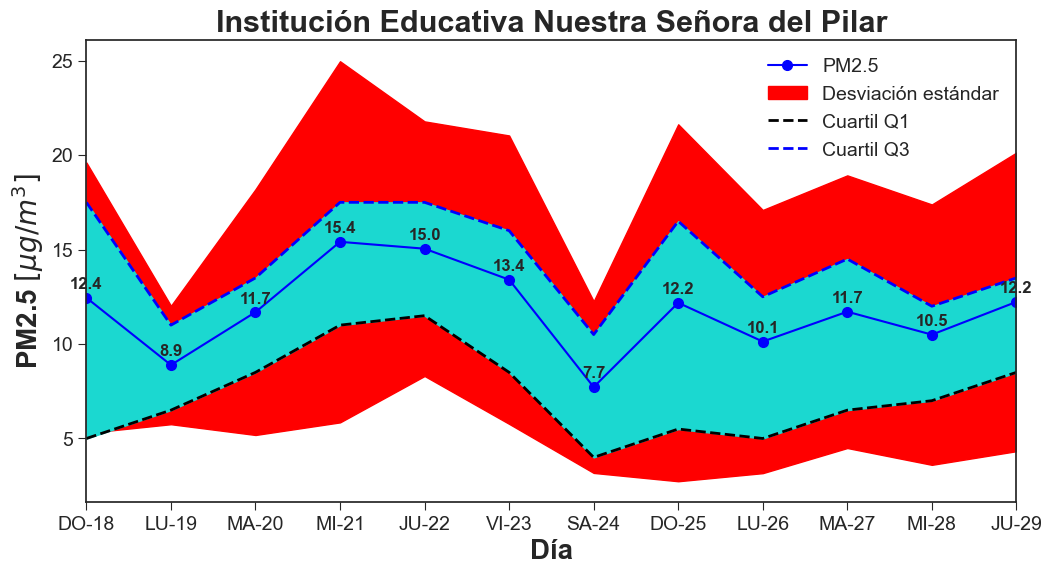

In [32]:
## Grafica mE1_0006
estacion = 'mE1_00006'
fig, ax = plt.subplots(figsize=(12,6))
graficar_datos(dat[estacion], dat_std[estacion], dat_Q1[estacion], dat_Q3[estacion],
                   ax, label = 'PM2.5', titulo = colegios[estacion], xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3)
plt.savefig('images/grafica'+estacion+'.png',dpi=400)

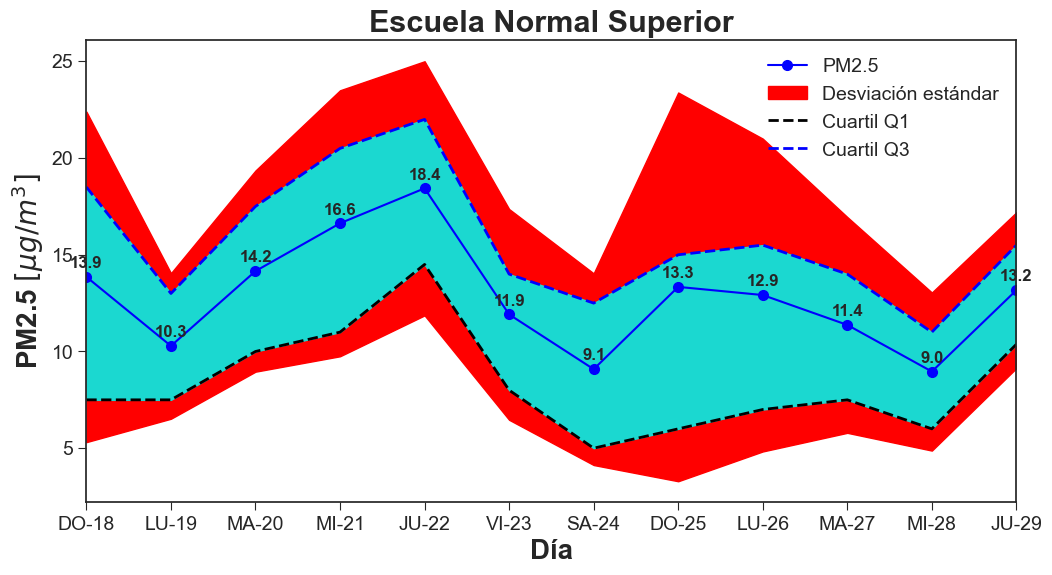

In [33]:
## Grafica mE1_00007
estacion = 'mE1_00007'
fig, ax = plt.subplots(figsize=(12,6))
graficar_datos(dat[estacion], dat_std[estacion], dat_Q1[estacion], dat_Q3[estacion],
                   ax, label = 'PM2.5', titulo = colegios[estacion], xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3)
plt.savefig('images/grafica'+estacion+'.png',dpi=400)

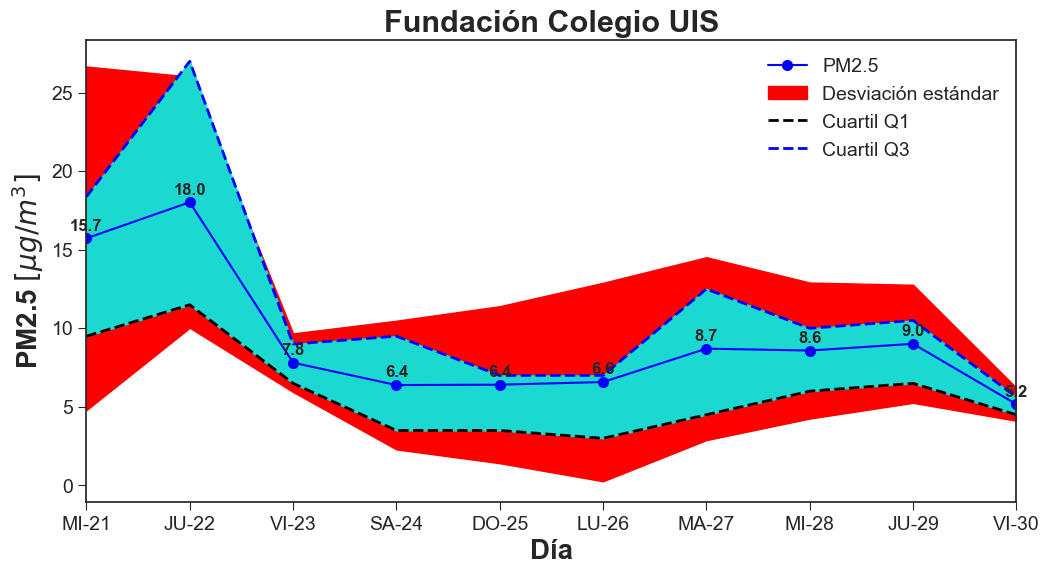

In [34]:
## Grafica mE1_00008
estacion = 'mE1_00008'
fig, ax = plt.subplots(figsize=(12,6))
graficar_datos(dat[estacion], dat_std[estacion], dat_Q1[estacion], dat_Q3[estacion],
                   ax, label = 'PM2.5', titulo = colegios[estacion], xlabel = 'Día', ylabel = 'PM2.5 $[\mu g / m^3]$',
                   col = 'pm25', alpha = 1, unit_text = 0.3)
plt.savefig('images/grafica'+estacion+'.png',dpi=400)